# Рекомендательные системы - проект

In [102]:
# Импортируем необходимые библиотеки:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))
        
import scipy.sparse as sparse

from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
import lightgbm as lgb

import sklearn
from sklearn.model_selection import train_test_split

import scipy.sparse as sparse

import surprise
from surprise import Reader, Dataset


In [103]:
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')

In [4]:
from sklearn.externals import joblib

ImportError: cannot import name 'joblib' from 'sklearn.externals' (C:\Anaconda\lib\site-packages\sklearn\externals\__init__.py)

In [ ]:
# чтение json
#with open(Path.cwd() / 'data' / 'meta_Grocery_and_Gourmet_Food.json') as f:
#    bebe = []
#    for line in f.readlines():
#        bebe.append(json.loads(line))

In [267]:
meta = pd.read_csv('Downloads/meta.csv/meta.csv')
meta.head(3)

,category,brand,rank,also_view,main_cat,price,asin,also_buy
0,"['Grocery & Gourmet Food', 'Dairy, Cheese & Eg...",Ariola Imports,"165,181inGroceryGourmetFood(","['B0000D9MYM', 'B0000D9MYL', 'B00ADHIGBA', 'B0...",Grocery,$41.91,0681727810,NaN
1,"['Grocery & Gourmet Food', 'Cooking & Baking',...",NaN,"315,867inGroceryGourmetFood(",NaN,Grocery,NaN,0853347867,"['B01898YHXK', 'B01BCM6LAC', 'B00Q4OL47O', 'B0..."
2,"['Grocery & Gourmet Food', 'Cooking & Baking',...",Unik Occasions,">#669,941 in Kitchen & Dining (See Top 100 in ...",['B07DXN65TF'],Amazon Home,$29.95,1888861118,NaN


In [172]:
# Читаем файлы
train = pd.read_csv('Downloads/recommendationsv4/train.csv')
test = pd.read_csv('Downloads/recommendationsv4/test.csv')
sample_submission = pd.read_csv('Downloads/recommendationsv4/sample_submission.csv')
#tags = pd.read_csv('Downloads/goodbooks-10k/goodbooks/tags.csv')


In [106]:
train.info()
train.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857895 entries, 0 to 857894
Data columns (total 14 columns):
overall           857895 non-null float64
verified          857895 non-null bool
reviewTime        857895 non-null object
asin              857895 non-null object
reviewerName      857719 non-null object
reviewText        857616 non-null object
summary           857725 non-null object
unixReviewTime    857895 non-null int64
vote              118740 non-null object
style             444406 non-null object
image             7142 non-null object
userid            857895 non-null int64
itemid            857895 non-null int64
rating            857895 non-null float64
dtypes: bool(1), float64(2), int64(3), object(8)
memory usage: 85.9+ MB


,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating
0,5.0,True,"10 4, 2016",B01CPNIEQG,Heather,These are my FAVORITE spices in my collection....,Must Add to your Spice kitchen!,1475539200,NaN,NaN,NaN,102179,37138,1.0
1,5.0,True,"03 1, 2016",B006F63M8U,Linda Odom,Add A package to my Coffee and it makes a good...,Milk Chocolate Swiis MIss Hot Cocoa Mix,1456790400,NaN,{'Size:': ' 60-0.73 oz Envelopes'},NaN,3625,17322,1.0
2,5.0,True,"06 26, 2016",B00112O8NG,DesertBlossom,"I love the Torani syrups, but not the prices o...","Love these sugar free syrups, but didn't love ...",1466899200,28,NaN,NaN,39495,5600,1.0


In [107]:
# Определим процент незаполненных данных в столбцах: удалим столбцы vote, style, image с пропусками более 48%

train.isnull().sum()/857895*100

overall            0.000000
verified           0.000000
reviewTime         0.000000
asin               0.000000
reviewerName       0.020515
reviewText         0.032521
summary            0.019816
unixReviewTime     0.000000
vote              86.159145
style             48.198090
image             99.167497
userid             0.000000
itemid             0.000000
rating             0.000000
dtype: float64

In [173]:
# Удалим столбцы с большим количеством пропусков, дату отзыва (оставим дату в формате unix), 

train = train.drop(['vote', 'style', 'image', 'reviewTime'], axis = 1)

In [108]:
test.info()
test.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285965 entries, 0 to 285964
Data columns (total 11 columns):
verified          285965 non-null bool
reviewTime        285965 non-null object
asin              285965 non-null object
reviewerName      285918 non-null object
unixReviewTime    285965 non-null int64
vote              39462 non-null object
style             147680 non-null object
image             2368 non-null object
userid            285965 non-null int64
itemid            285965 non-null int64
Id                285965 non-null int64
dtypes: bool(1), int64(4), object(6)
memory usage: 22.1+ MB


,verified,reviewTime,asin,reviewerName,unixReviewTime,vote,style,image,userid,itemid,Id
0,True,"10 1, 2016",B001E5E3X0,Rudys Mom,1475280000,NaN,NaN,NaN,68877,7506,0
1,True,"06 29, 2014",B005BYXX5E,pharg,1404000000,2,NaN,NaN,50442,15530,1
2,True,"05 19, 2015",B0052OK6OO,dhalex,1431993600,NaN,NaN,NaN,64349,15049,2


In [110]:
test.isnull().sum()/857895*100

verified           0.000000
reviewTime         0.000000
asin               0.000000
reviewerName       0.005479
unixReviewTime     0.000000
vote              28.733470
style             16.119105
image             33.057309
userid             0.000000
itemid             0.000000
Id                 0.000000
dtype: float64

In [174]:
# Аналогично, удалим на тесте такие же колонки

test = test.drop(['vote', 'style', 'image', 'reviewTime'], axis = 1)

In [ ]:
Видим, что в тренировочном датасете на три столбца больше:

overall - оценка по пятибальной шкале
summary - краткое содержание отзыва
rating - целевая переменная
Создадим копию расширенного датасета df_new, чтобы каждый раз заново не загружать данные, если что-то испортим.

In [112]:
train_copy = train.copy()

In [113]:
# Функция без гистограммы
def col_info(ys):
    print('Количество пропусков: {},'.format(ys.isnull().sum()))
    print('{},'.format(ys.describe()))
    print('Распределение:\n{},'.format(ys.value_counts()))

# Функция с гистограммой
def col_info_hist(ys):
    print('Количество пропусков: {},'.format(ys.isnull().sum()))
    print('{},'.format(ys.describe()))
    print('Распределение:\n{},'.format(ys.value_counts()))
    ys.hist()

Количество пропусков: 0,
count    781124.000000
mean          4.433488
std           1.069696
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64,
Распределение:
5.0    556868
4.0    104296
3.0     56087
1.0     34427
2.0     29446
Name: overall, dtype: int64,


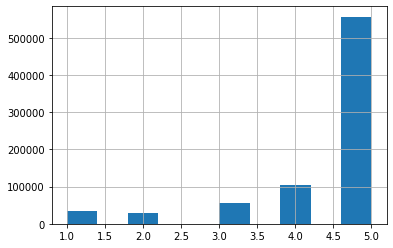

In [185]:
# Overall
col_info_hist(train.overall)
train['overall']=train['overall'].astype('int32')

In [175]:
# verified  Пропусков нет. Заменим значения на бинарные 1 и 0.

col_info(train.verified)
dic_verified = {
    True: 1,
    False: 0
}
train['verified'] = train['verified'].map(dic_verified)

Количество пропусков: 0,
count     857895
unique         2
top         True
freq      745243
Name: verified, dtype: object,
Распределение:
True     745243
False    112652
Name: verified, dtype: int64,


Средняя оценка при значении verified = 1:  4.4803010561655725
Средняя оценка при значении verified = 0:  4.186299399921883


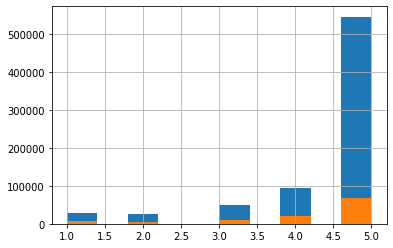

In [118]:
# Посмотрим, как влияет признак verified на среднюю оценку. 
# Видим, что средняя оценка товаров с признаком verified = 1 выше, но в целом распределение оценок похожее.

print('Средняя оценка при значении verified = 1: ',train[train.verified == 1].overall.mean())
train['overall'][train['verified'] == 1].hist(bins=10)
print('Средняя оценка при значении verified = 0: ',train[train.verified == 0].overall.mean())
train['overall'][train['verified'] == 0].hist(bins=10)

In [121]:
# reviewerName
# Видим, что довольно много отзывов с Амазона и Киндла. 180 пропусков. Проверим, один userid у Amazon Customer, или одному имени пользователя может соответствовать несколько userid.
# В таком случае, имя пользователя нам не нужно. Удалим столбец.

col_info(train.reviewerName)
train[train.reviewerName=='Amazon Customer'].userid.value_counts()

Количество пропусков: 176,
count              857719
unique             101207
top       Amazon Customer
freq                31726
Name: reviewerName, dtype: object,
Распределение:
Amazon Customer         31726
Kindle Customer          6228
Linda                     734
John                      725
David                     619
                        ...  
SecretMourning              1
Caroline Graettinger        1
Noman                       1
donna bruno                 1
seasoned shopper            1
Name: reviewerName, Length: 101207, dtype: int64,


In [176]:
train = train.drop(['reviewerName'], axis=1)

[1. 0.]


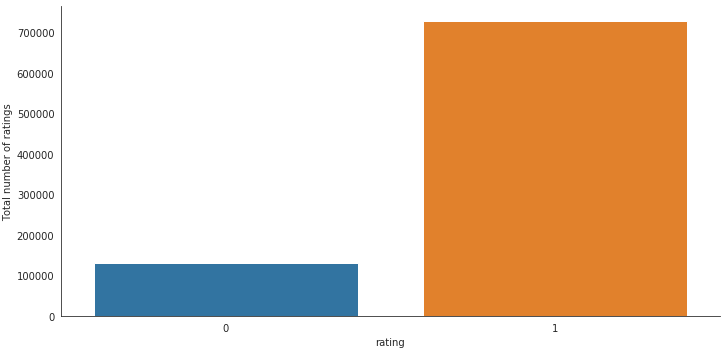

In [177]:
#  rating - бинарная оценка продукта - понравился или нет

print(train['rating'].unique())
train['rating'] = train['rating'].apply(lambda x: int(x))
with sns.axes_style('white'):
    g = sns.factorplot("rating", data=train, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

reviewText и summary
Попытка вычленить оценки из текста привела к тем же оценкам, которые уже есть в датасете. Поэтому код ниже можно не выполнять

In [34]:
# Создадим новые признаки оценок пользователя из значений reviewText и summary

words_5 = ['favorite', 'nice', 'great', 'best', 'favorite', 'wonderful', 'love', 'five stars', 'magic', 'perfect','very nice', 'lucky' ]
words_4 = ['good', 'better', 'four stars', 'glad', 'surprised']
words_3 = ['three stars']
words_1 = ['break', "I'd not buy", 'bad', 'one star']
 
train['reviewText'] = train['reviewText'].fillna('no')
train['summary'] = train['summary'].fillna('no')

def rate (desc):
# функция определяет оценку на основании отзыва по реперным словам
    
    desc = desc.lower()
    for w in words_1:
        if w in desc:
            return 1
    for w in words_5:
        if w in desc:
            return 5  
    for w in words_4:
        if w in desc:
            return 4 
        elif  words_3[0] in desc:
            return 3
        else:
            return 2 
    
train['rate_rewiew'] = train['reviewText'].apply(rate)  
print('ok1')
train['rate_summary'] = train['summary'].apply(rate)   
print('ok2')

for i in range(0,len(train)):       # оставим большую из оценок
    train['rate_summary'][i] =  max(train['rate_summary'][i], train['rate_rewiew'][i])
    
display(train['rate_rewiew'].value_counts())
display(train['rate_summary'].value_counts())
train[train.rate_rewiew != train.rate_summary]

jr


[5 4 2 1 3]
[5. 4. 1. 2. 3.]


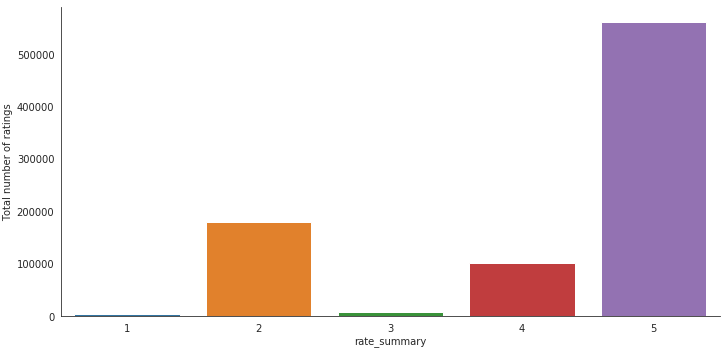

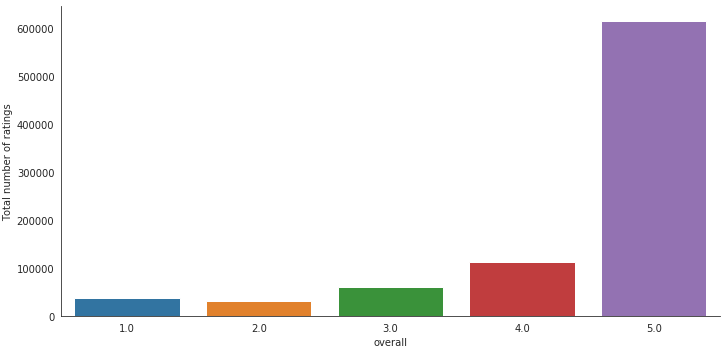

In [89]:
# Сравним диаграммы оценок, определенных из отзывов, и проставленных пользователем.
# Есть различие между распределением оценок1, 2, 3, но в остальном пропорция сохраняется, особенно если делить на 'хорошие' и 'плохие' оценки
# Можно сделать вывод, что поле rating собственно и отражает деление на  'хорошие' и 'плохие' оценки

print(train['rate_summary'].unique())
with sns.axes_style('white'):
    g = sns.factorplot("rate_summary", data=train, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")
                  
print(train['overall'].unique())
with sns.axes_style('white'):
    g = sns.factorplot("overall", data=train, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [178]:
# Удалим столбцы с отзывами 

train = train.drop(['summary', 'reviewText'], axis=1)

In [138]:
# asin идентификатор для модели 

col_info(train.asin)

Количество пропусков: 0,
count         857895
unique         41302
top       B00BUKL666
freq            5491
Name: asin, dtype: object,
Распределение:
B00BUKL666    5491
B00D3M2QP4    4733
B008QMX2SG    4654
B00R7PWK7W    2547
B000X3TPHS    2300
              ... 
B00FKZTBBO       1
B01BB9N9QA       1
B0012QDZBM       1
B005CJUXOM       1
B005TY2FQY       1
Name: asin, Length: 41302, dtype: int64,


Количество пропусков: 0,
count    8.578950e+05
mean     1.441755e+09
std      5.973571e+07
min      9.657792e+08
25%      1.411949e+09
50%      1.449101e+09
75%      1.484870e+09
max      1.538438e+09
Name: unixReviewTime, dtype: float64,
Распределение:
1456790400    942
1468454400    885
1433289600    799
1453248000    795
1455926400    784
             ... 
1134086400      1
1196812800      1
1184025600      1
1178150400      1
1144454400      1
Name: unixReviewTime, Length: 4580, dtype: int64,


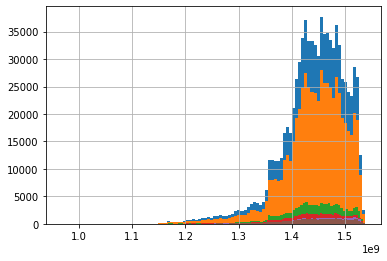

In [129]:
# unixReviewTime  Пропусков нет. Посмотрим, как изменялись оценки со временем.

col_info(train.unixReviewTime)
train.unixReviewTime.hist(bins=100)
train[train.overall == 5].unixReviewTime.hist(bins=100)
train[train.overall == 4].unixReviewTime.hist(bins=100)
train[train.overall == 3].unixReviewTime.hist(bins=100)
train[train.overall == 1].unixReviewTime.hist(bins=100)
train[train.overall == 2].unixReviewTime.hist(bins=100)

In [179]:
from datetime import datetime
tsmin = train.unixReviewTime.min()
ts25 = int(train.unixReviewTime.quantile(0.25))
ts50 = int(train.unixReviewTime.quantile(0.50))
ts75 = int(train.unixReviewTime.quantile(0.75))
tsmax = train.unixReviewTime.max()
print('Самый первый отзыв:', datetime.utcfromtimestamp(tsmin).strftime('%Y-%m-%d %H:%M:%S'))
print('25 квантиль:', datetime.utcfromtimestamp(ts25).strftime('%Y-%m-%d %H:%M:%S'))
print('50 квантиль:', datetime.utcfromtimestamp(ts50).strftime('%Y-%m-%d %H:%M:%S'))
print('75 квантиль:', datetime.utcfromtimestamp(ts75).strftime('%Y-%m-%d %H:%M:%S'))
print('Последний отзыв:', datetime.utcfromtimestamp(tsmax).strftime('%Y-%m-%d %H:%M:%S'))

Самый первый отзыв: 2000-08-09 00:00:00
25 квантиль: 2014-09-29 00:00:00
50 квантиль: 2015-12-03 00:00:00
75 квантиль: 2017-01-20 00:00:00
Последний отзыв: 2018-10-02 00:00:00


In [180]:
# Создадим 4 категории в зависимости от даты написания
def cat_date(x):
    if x <= ts25: x = 4
    elif ts25 < x <= ts50: x = 3
    elif ts50 < x <= ts75: x = 2
    elif ts75 < x: x = 1
    return x      

# Заменим значения в столбце на категории
train['unixReviewTime'] = train['unixReviewTime'].apply(lambda x: cat_date(x))

In [ ]:
# Удалим дубликаты

train = train.drop_duplicates(keep=False, inplace=False)

In [186]:
train

,overall,verified,asin,unixReviewTime,userid,itemid,rating
0,5,1,B01CPNIEQG,2,102179,37138,1
1,5,1,B006F63M8U,2,3625,17322,1
2,5,1,B00112O8NG,2,39495,5600,1
3,5,1,B00MRAQUM8,4,72854,30249,1
4,5,1,B000R7RN0G,2,74859,4349,1
...,...,...,...,...,...,...,...
857888,5,1,B00E9OWXGW,3,74258,24577,1
857889,5,1,B008QMX2SG,2,70292,24556,1
857892,4,0,B000LKX6R8,2,88,3251,1
857893,4,1,B00BUKL666,3,41540,22208,1


# EDA test

In [161]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285965 entries, 0 to 285964
Data columns (total 5 columns):
verified          285965 non-null int64
asin              285965 non-null object
unixReviewTime    285965 non-null int64
userid            285965 non-null int64
itemid            285965 non-null int64
dtypes: int64(4), object(1)
memory usage: 10.9+ MB


In [154]:
test.Id.unique()

array([     0,      1,      2, ..., 285962, 285963, 285964], dtype=int64)

In [247]:
# Удалим reviewerName как и в train, и Id как дублирующий

test = test.drop(['reviewerName', 'Id'], axis = 1)

In [252]:
test[test.asin == 'B000A7Q2J6']

,verified,asin,unixReviewTime,userid,itemid,rating


In [253]:
train[train.asin == 'B0007OXDOO']

,overall,verified,asin,unixReviewTime,userid,itemid,rating


In [158]:
test.isnull().sum()/857895*100

verified          0.0
asin              0.0
unixReviewTime    0.0
userid            0.0
itemid            0.0
dtype: float64

In [245]:
test['verified'] = test['verified'].apply(lambda x: 1 if True else 0)

# EDA meta

In [230]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287209 entries, 0 to 287208
Data columns (total 9 columns):
Unnamed: 0    287209 non-null int64
category      287209 non-null object
brand         275766 non-null object
rank          275494 non-null object
also_view     121012 non-null object
main_cat      285716 non-null object
price         132136 non-null object
asin          287209 non-null object
also_buy      83332 non-null object
dtypes: int64(1), object(8)
memory usage: 19.7+ MB


In [234]:
meta.isnull().sum()/857895*100

category      0.000000
brand         1.333846
rank          1.365552
also_view    19.372650
main_cat      0.174031
price        18.075988
asin          0.000000
also_buy     23.764796
dtype: float64

In [228]:
# ВСе нижеприведенные столбцы проверены на уникальность и содержание, а также на количество пропусков. Принято решение - удалить их.

meta = meta.drop(['fit', 'tech1', 'similar_item', 'image', 'date', 'feature', 'details', 'description', 'title', 'Unnamed: 0'], axis = 1)

In [254]:
# Объединим 

train2 = train.merge(meta, on='asin', how='left')
train2[:5]

,overall,verified,asin,unixReviewTime,userid,itemid,rating,category,brand,rank,also_view,main_cat,price,also_buy
0,5,1,B01CPNIEQG,2,102179,37138,1,"['Grocery & Gourmet Food', 'Herbs, Spices & Se...",Primal Palate Organic Spices,"19,771inGroceryGourmetFood(","['B00AJRKRJS', 'B01NALHAY9', 'B01DGZ2B48', 'B0...",Grocery,$9.95,"['B01DGZ2B48', 'B01EZ489AO', 'B01DH795LM', 'B0..."
1,5,1,B006F63M8U,2,3625,17322,1,"['Grocery & Gourmet Food', 'Beverages', 'Coffe...",Swiss Miss,"5,591inGroceryGourmetFood(",NaN,Grocery,$18.49,"['B001FBKO4U', 'B00BJ9URYA', 'B00451ZJB0', 'B0..."
2,5,1,B00112O8NG,2,39495,5600,1,"['Grocery & Gourmet Food', 'Beverages', 'Bottl...",Torani,NaN,"['B006K3UC86', 'B000WGB3OY']",Grocery,NaN,"['B000T9WLUY', 'B01K23RF7U', 'B0015GSBUY', 'B0..."
3,5,1,B00MRAQUM8,4,72854,30249,1,"['Grocery & Gourmet Food', 'Herbs, Spices & Se...",Frontier,"168,917inGroceryGourmetFood(",NaN,Grocery,$44.95,"['B00416T7E4', 'B0001M11DC', 'B001VNO1NM', 'B0..."
4,5,1,B000R7RN0G,2,74859,4349,1,"['Grocery & Gourmet Food', 'Snack Foods', 'Chi...",Miss Vickie's,"61,690inGroceryGourmetFood(","['B006WYSG6S', 'B00F0C0S2I', 'B00CWYM3OI', 'B0...",Grocery,NaN,"['B000R7XBF2', 'B000HIFA8W', 'B000R7RODW', 'B0..."


In [358]:
train3.isnull().sum()/857895*100

overall           0.0
verified          0.0
unixReviewTime    0.0
userid            0.0
itemid            0.0
rating            0.0
brand             0.0
main_cat          0.0
price             0.0
dtype: float64

# category и main_cat
Заполним пропущенные значения главной категории первым значением их списка категорий, удалим столбец со списком всех категорий

In [288]:
train2['main_cat'] = train2['main_cat'].fillna(train2['category'].apply(lambda x: x.split(',')[0]))

In [298]:
def category (cat):
    if cat == "['Grocery & Gourmet Food'":
        return 'Grocery'
    else:
        return cat

In [299]:
train2['main_cat'] = train2['main_cat'].apply(category)

In [303]:
train2 = train2.drop(['category'], axis=1)
train2['main_cat'].unique()


array(['Grocery', 'Health & Personal Care', 'Office Products',
       'Sports & Outdoors', 'Amazon Home', 'Toys & Games',
       'Industrial & Scientific', 'All Beauty',
       'Tools & Home Improvement', 'Baby', 'Pet Supplies',
       'Home Audio & Theater', 'Arts, Crafts & Sewing', 'Camera & Photo',
       'Cell Phones & Accessories', 'Software', 'Musical Instruments'],
      dtype=object)

In [317]:
# also_buy. Заполним пустые значения значениями also_view

train2['also_buy'] = train2['also_buy'].fillna(train2['also_view'])

In [326]:
train2['also_buy'] = train2['also_buy'].fillna(train2['rank'].apply(lambda x: str(x).split(',')[0]))

In [334]:
train2['also_buy'] = train2['also_buy'].apply(lambda x: str(x).replace('>#',''))

In [344]:
def asin (asin_list):
   # id_list = []
    asin_list = asin_list.split(',')
    if len(asin_list)==1:
        id_list.append(asin_list)


In [345]:
id_list = []
train2['also_buy'].apply(asin)

0         None
1         None
2         None
3         None
4         None
          ... 
799093    None
799094    None
799095    None
799096    None
799097    None
Name: also_buy, Length: 799098, dtype: object

In [350]:
id_list.sort()
id_list

[['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],
 ['1'],


In [352]:
# устала бороться с заполнением, удаляем столбцы

train3 = train2.drop(['rank', 'also_view', 'also_buy', 'asin'], axis=1)

In [353]:
train3

,overall,verified,unixReviewTime,userid,itemid,rating,brand,main_cat,price
0,5,1,2,102179,37138,1,Primal Palate Organic Spices,Grocery,$9.95
1,5,1,2,3625,17322,1,Swiss Miss,Grocery,$18.49
2,5,1,2,39495,5600,1,Torani,Grocery,NaN
3,5,1,4,72854,30249,1,Frontier,Grocery,$44.95
4,5,1,2,74859,4349,1,Miss Vickie's,Grocery,NaN
...,...,...,...,...,...,...,...,...,...
799093,5,1,3,74258,24577,1,Nongshim,Grocery,NaN
799094,5,1,2,70292,24556,1,KIND,Grocery,$14.79
799095,4,0,2,88,3251,1,Hakubaku,Grocery,$22.45
799096,4,1,3,41540,22208,1,KIND,Grocery,$13.67


In [354]:
train3['brand'].value_counts()

KIND                              21048
Bob's Red Mill                    11656
Twinings                          10209
Planters                           9898
Green Mountain Coffee Roasters     6648
                                  ...  
Tsogo                                 1
Market America                        1
cocomama                              1
Wheat Nuts                            1
Mallo Cup                             1
Name: brand, Length: 8847, dtype: int64

In [355]:
train3['brand'] = train3['brand'].fillna('KIND')

In [357]:
from collections import Counter
import json
import re
# Скопируем датасет
df_price = train3.copy()
# Избавимся от пропусков
df_price = df_price[df_price.price.isna() == False]
df_price = df_price[df_price.price != '']
# Приведем все к str
df_price['price'] = df_price['price'].astype('str')
# Удалим все значения кроме числовых
df_price['price'] = df_price['price'].apply(lambda x: re.sub('\D', '', x))
# Переведем во float
df_price['price'] = df_price['price'].astype('float')
# Удалим все, что дороже 9999$ т.к. это, скорее всего, ошибка
df_price = df_price[df_price.price < 999999]


df_price_mean = df_price.price.mean()
# Приведем все к str
train3['price'] = train3['price'].astype('str')
# Удалим все значения кроме числовых
train3['price'] = train3['price'].apply(lambda x: re.sub('\D', '', x))
# Заменим пропуски на среднее значение
train3['price'] = train3['price'].apply(lambda x: round(df_price_mean, 0) if x == '' else x)
# Приведем к float
train3['price'] = train3['price'].astype('float')
# Заменим большие значения на средние
train3['price'] = train3['price'].apply(lambda x: round(df_price_mean, 0) if x > 999999 else x)
# Приведем к int32
train3['price'] = train3['price'].astype('int32')

In [359]:
train3

,overall,verified,unixReviewTime,userid,itemid,rating,brand,main_cat,price
0,5,1,2,102179,37138,1,Primal Palate Organic Spices,Grocery,995
1,5,1,2,3625,17322,1,Swiss Miss,Grocery,1849
2,5,1,2,39495,5600,1,Torani,Grocery,2075
3,5,1,4,72854,30249,1,Frontier,Grocery,4495
4,5,1,2,74859,4349,1,Miss Vickie's,Grocery,2075
...,...,...,...,...,...,...,...,...,...
799093,5,1,3,74258,24577,1,Nongshim,Grocery,2075
799094,5,1,2,70292,24556,1,KIND,Grocery,1479
799095,4,0,2,88,3251,1,Hakubaku,Grocery,2245
799096,4,1,3,41540,22208,1,KIND,Grocery,1367


# Reader колабративная фильтрация методом ближайших соседей

In [ ]:
# Результат этого алгоритма на кагл не впечатляет  = 0.6

In [10]:
user_sample = train.userid.sample(100000)
item_sample = train.itemid.sample(50000)

In [99]:
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(train[train.userid.isin(user_sample) &
                              train.itemid.isin(item_sample)][['userid', 'itemid', 'overall']], reader)

In [12]:
from surprise import KNNBasic

sim_options = {
    'name': 'cosine',
    'user_based': False
}
 
knn = KNNBasic(sim_options=sim_options)

In [13]:
trainingSet = data.build_full_trainset()

In [14]:
model = knn.fit(trainingSet)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [17]:
test['rating'] = 0
test

,verified,reviewTime,asin,reviewerName,unixReviewTime,vote,style,image,userid,itemid,Id,rating
0,True,"10 1, 2016",B001E5E3X0,Rudys Mom,1475280000,NaN,NaN,NaN,68877,7506,0,0
1,True,"06 29, 2014",B005BYXX5E,pharg,1404000000,2,NaN,NaN,50442,15530,1,0
2,True,"05 19, 2015",B0052OK6OO,dhalex,1431993600,NaN,NaN,NaN,64349,15049,2,0
3,True,"10 5, 2014",B003SO8HGE,Vanessa,1412467200,NaN,{'Flavor:': ' Sweet Rose'},NaN,26206,11957,3,0
4,True,"11 11, 2013",B003XUJ564,R Mohrman,1384128000,3,"{'Size:': ' 15 Ounce (Pack of 12)', 'Flavor:':...",NaN,59366,12173,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
285960,True,"01 17, 2016",B00FLD3X28,A. Banks,1452988800,NaN,{'Size:': ' 1 Pound'},NaN,294,25601,285960,0
285961,True,"08 22, 2015",B0078DQ85S,HighEnergy,1440201600,NaN,{'Flavor:': ' Cinnamon & Currant'},NaN,119653,18204,285961,0
285962,True,"09 21, 2017",B000FZVLFS,Sam Jackson,1505952000,NaN,{'Flavor:': ' Espresso Forte'},NaN,54673,2287,285962,0
285963,True,"03 27, 2018",B001PB801Y,Louis J. Dezseran Sr.,1522108800,NaN,{'Size:': ' 5lb'},NaN,16569,9343,285963,0


In [20]:
test2 = Dataset.load_from_df(test[['userid', 'itemid', 'rating']], reader)

In [21]:
testSet = test2.construct_testset(test2.raw_ratings)

In [22]:
predictions2 = knn.test(testSet)
predictions2

[Prediction(uid=68877, iid=7506, r_ui=0.0, est=4.4564591781436285, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid=50442, iid=15530, r_ui=0.0, est=4.4564591781436285, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid=64349, iid=15049, r_ui=0.0, est=4.4564591781436285, details={'was_impossible': True, 'reason': 'Not enough neighbors.'}),
 Prediction(uid=26206, iid=11957, r_ui=0.0, est=4.4564591781436285, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid=59366, iid=12173, r_ui=0.0, est=4.4564591781436285, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid=2467, iid=13076, r_ui=0.0, est=4.4564591781436285, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid=49329, iid=26418, r_ui=0.0, est=5.0, details={'actual_k': 4, 'was_impossible': False}),
 Prediction(uid=25316, iid=5734, r_

In [32]:
sample_submission['rating']=[pred.est for pred in predictions2]

In [33]:
sample_submission.to_csv('rec_submission_6.csv', index=False)

# SVD

In [ ]:
# Результат этого алгоритма на кагл тоже не особо  = 0.70282

In [201]:
user_sample = train.userid.sample(127024)
item_sample = train.itemid.sample(41247)

In [202]:
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(train[train.userid.isin(user_sample) &
                              train.itemid.isin(item_sample)][['userid', 'itemid', 'overall']], reader)

In [203]:
from surprise import SVD

In [204]:
svd=SVD()
trainingSet=data.build_full_trainset()

In [205]:
test['rating'] = 0

In [206]:
data_test = Dataset.load_from_df(test[['userid', 'itemid', 'rating']], reader)

In [207]:
svd.fit(trainingSet)

In [208]:
testSet = data_test.construct_testset(data_test.raw_ratings)

In [209]:
#testSet=test.build_full_trainset()
predictions3 = svd.test(testSet)
predictions3

[Prediction(uid=68877, iid=7506, r_ui=0.0, est=4.625988882949925, details={'was_impossible': False}),
 Prediction(uid=50442, iid=15530, r_ui=0.0, est=4.5433181598173915, details={'was_impossible': False}),
 Prediction(uid=64349, iid=15049, r_ui=0.0, est=4.598130993075361, details={'was_impossible': False}),
 Prediction(uid=26206, iid=11957, r_ui=0.0, est=4.013804304735343, details={'was_impossible': False}),
 Prediction(uid=59366, iid=12173, r_ui=0.0, est=4.122603391050633, details={'was_impossible': False}),
 Prediction(uid=2467, iid=13076, r_ui=0.0, est=4.4463187875283445, details={'was_impossible': False}),
 Prediction(uid=49329, iid=26418, r_ui=0.0, est=4.4463187875283445, details={'was_impossible': False}),
 Prediction(uid=25316, iid=5734, r_ui=0.0, est=4.5476374879608565, details={'was_impossible': False}),
 Prediction(uid=108256, iid=28914, r_ui=0.0, est=4.201685380650908, details={'was_impossible': False}),
 Prediction(uid=20220, iid=3050, r_ui=0.0, est=4.2314984599566285, deta

In [210]:
sample_submission['rating']=[pred.est for pred in predictions3]

In [212]:
#normalized_preds = (sample_submission['rating'] - sample_submission['rating'].min())/(sample_submission['rating'] - sample_submission['rating'].min()).max()

In [213]:
#sample_submission['rating']=normalized_preds

In [214]:
sample_submission.to_csv('rec_submission_10.csv', index=False)

In [378]:
train3.main_cat.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
      dtype=int64)

In [374]:
dic_cat = {
    'Grocery': 1, 
    'Health & Personal Care': 2, 
    'Office Products':3,
    'Sports & Outdoors':4, 
    'Amazon Home':4, 
    'Toys & Games':5,
    'Industrial & Scientific':6, 
    'All Beauty':7,
    'Tools & Home Improvement':8, 
    'Baby':9, 
    'Pet Supplies':10,
    'Home Audio & Theater':11, 
    'Arts, Crafts & Sewing':12, 
    'Camera & Photo':13,
    'Cell Phones & Accessories': 14, 
    'Software':15, 
    'Musical Instruments':16
}

train3['main_cat'] = train3['main_cat'].map(dic_cat)

In [413]:
train3.brand.unique()

array(['Primal Palate Organic Spices', 'Swiss Miss', 'Torani', ...,
       'Peanut Butter Americano', 'Barefoot Contessa Pantry',
       'Genesis Today'], dtype=object)

# LIGHTFM без фич

In [360]:
#число потоков нашего процессора
NUM_THREADS = 8

#число параметров вектора 
NUM_COMPONENTS = 30 

#число эпох обучения
NUM_EPOCHS = 20 

In [80]:
#Создаём модель
#model = LightFM(learning_rate=0.05, loss='warp', no_components=NUM_COMPONENTS)


In [414]:
 
#Разбиваем наш датасет на обучающую и тестовую выборки
#trainy,testy = random_train_test_split(ratings_coo, test_percentage=0.2, random_state=32)
train_data, test_data = train_test_split(train3,random_state=32, shuffle=True)

In [415]:
ratings_coo = sparse.coo_matrix((train_data['rating'].astype(int),
                                 (train_data['userid'],
                                  train_data['itemid'])))

# ratings_coo = sparse.coo_matrix((train2.overall,(train2.userid,train2.itemid)))

In [416]:
# без фич

model = LightFM(learning_rate=0.1, loss='logistic',
                no_components=NUM_COMPONENTS)
model = model.fit(ratings_coo, epochs=NUM_EPOCHS, 
                  num_threads=NUM_THREADS)

In [95]:
from scipy.sparse import coo_matrix, hstack
A = coo_matrix([[1, 2], [3, 4]])
B = coo_matrix([[5], [6]])
hstack([A,B]).toarray()

array([[1, 2, 5],
       [3, 4, 6]], dtype=int32)

In [82]:
#Обучаем модель
#model = model.fit(trainy, epochs=NUM_EPOCHS, num_threads=NUM_THREADS,item_features =feature_ratings)

In [ ]:
#0.7297085731514241 - 0.07, 0.7299 - 0.1,  0.7272- cat в цифры

In [417]:
predst = model.predict(test_data.userid.values,
                      test_data.itemid.values)
sklearn.metrics.roc_auc_score(test_data.rating, predst)

0.7287939961067629

In [52]:
preds = model.predict(test.userid.values,
                      test.itemid.values)

In [55]:
print(preds.min(), preds.max())


-2.1322097778320312 4.268839359283447


In [54]:
normalized_preds = (preds - preds.min())/(preds - preds.min()).max()

In [56]:
print(normalized_preds.min(), normalized_preds.max())

0.0 1.0


In [57]:
sample_submission['rating']= normalized_preds
sample_submission.to_csv('rec_submission_9.csv', index=False)

# LIGHTFM с фичами

In [421]:
#число потоков нашего процессора
NUM_THREADS = 8

#число параметров вектора 
NUM_COMPONENTS = 30 

#число эпох обучения
NUM_EPOCHS = 20 

In [422]:
#Разбиваем наш датасет на обучающую и тестовую выборки
#trainy,testy = random_train_test_split(ratings_coo, test_percentage=0.2, random_state=32)
train_data, test_data = train_test_split(train3,random_state=32, shuffle=True)

In [459]:
train3.head(3)

,overall,verified,unixReviewTime,userid,itemid,rating,brand,main_cat,price
0,5,1,2,102179,37138,1,Primal Palate Organic Spices,1,995
1,5,1,2,3625,17322,1,Swiss Miss,1,1849
2,5,1,2,39495,5600,1,Torani,1,2075


In [456]:
from lightfm.data import Dataset

In [457]:
dataset1 = Dataset()

In [460]:
uf = []
col = ['unixReviewTime']*len(train3.unixReviewTime.unique()) + ['brand']*len(train3.brand.unique()) + ['main_cat']*len(train3.main_cat.unique()) + ['price']*len(train3['price'].unique())
unique_f1 = list(train3.unixReviewTime.unique()) + list(train3.brand.unique()) + list(train3.main_cat.unique()) + list(train3['price'].unique())
#print('f1:', unique_f1)
for x,y in zip(col, unique_f1):
    res = str(x)+ ":" +str(y)
    uf.append(res)
    print(res)

unixReviewTime:2
unixReviewTime:4
unixReviewTime:1
unixReviewTime:3
brand:Primal Palate Organic Spices
brand:Swiss Miss
brand:Torani
brand:Frontier
brand:Miss Vickie's
brand:Traditional Medicinals
brand:Madhava
brand:Reese's
brand:Designer Protein
brand:Kinder
brand:Choice Organic Teas
brand:Indus Organics
brand:Briceo Coffee
brand:Bob's Red Mill
brand:Kirkland Signature
brand:SToK
brand:Diedrich Coffee
brand:Coffee People
brand:Talking Rain
brand:Stash Tea
brand:L.R. Rice
brand:Amoretti
brand:Twinings
brand:Harney & Sons
brand:Barilla
brand:V8
brand:Hoosier Hill Farm
brand:Snack Pack
brand:Starburst
brand:Glutino
brand:Two Rivers LLC
brand:Kernel Season's
brand:Unknown
brand:Nutiva
brand:Oregon's Wild Harvest
brand:Domino
brand:KIND
brand:Davidson's Tea
brand:Lance
brand:Hawaiian Host
brand:Bearitos
brand:Numi Organic Tea
brand:Casey Ann's Candies
brand:Honest Raw Honey
brand:Royal Dates
brand:Green Mountain Coffee Roasters
brand:CalPure
brand:Brown and Haley
brand:YumEarth
brand:Zomb

brand:Red Rose
brand:St. Dalfour
brand:Serendipity
brand:Nestle Nespresso
brand:Assumption Abbey
brand:Buy Candy Wholesale
brand:Health Valley
brand:Welch'ss
brand:CoCo Libre
brand:Great River Organic Milling
brand:CandyOut
brand:Nabisco
brand:Spicely Organics
brand:Tendergrass Farms
brand:Just BARE Chicken
brand:Alma Gourmet
brand:QIAYA
brand:Baronet Coffee
brand:Lily`s Sweets
brand:AQUAhydrate
brand:O'Dells
brand:David's Cookies
brand:Royal Oak Peanuts
brand:Jiva
brand:thinkThin
brand:Copper Moon
brand:Victoria Taylor's
brand:The Air Plant Shop
brand:A-1
brand:Four Sigma Foods
brand:Ojai Cook
brand:Tootsie Roll
brand:Stonewall Kitchen
brand:Arizona Vanilla
brand:Pacific Resources
brand:Matcha Love
brand:Eclipse Gum
brand:Pioneer Valley
brand:SAF
brand:Torie & Howard
brand:LorAnn Super-Strength
brand:Mt Capra
brand:BUNN
brand:Honeyville Grain
brand:Food for Life
brand:Chung Jung One
brand:JHC
brand:WANT
brand:Life & Food
brand:SpaghettiOs
brand:Dei Fratelli
brand:Hoody's
brand:Walnut 

brand:Explore Asia
brand:Deruyter
brand:Ferara
brand:Biermann Marzipan
brand:Loc Maria
brand:Amy & Brian
brand:Hotlix
brand:Ricochet
brand:Bassetts Trebor
brand:Jake and Amos
brand:Espua Tapas Essentials
brand:Total
brand:Coffee Bitch Slap
brand:Winona Pure
brand:Longevity
brand:Big Cock Ranch
brand:MARANATHA
brand:Reber
brand:Sam Mills
brand:Druids Grove
brand:The Body Shop
brand:Yasso
brand:Lake Champlain Chocolates
brand:Texas Pepper Works
brand:Better Than Milk
brand:KP Snake
brand:Crown Candy
brand:Waiakea
brand:Squire Boone Village
brand:DRY Sparkling
brand:Classic Provisions Spices
brand:Natural Value
brand:24 MANTRA
brand:Matthew Walker
brand:Dagashi
brand:Water Sensations
brand:CTL Foods
brand:Mediterranean Snacks
brand:Lucky Foods LLC
brand:Nonni
brand:The Tea Factory
brand:Nektar Naturals
brand:Mighty Leaf
brand:Mazola
brand:Buddha's Herbs
brand:Stew Leonard's
brand:HazerBaba
brand:Honua Honey
brand:Pennsylvania Dutch
brand:Skyline
brand:Ahmad
brand:Creative Snacks
brand:Jil

brand:Garland Jack's
brand:Nature Valley Breakfast Biscuits Bluberry 18 Pouch
brand:Frontier Soups
brand:Magic&shell
brand:Delacre
brand:Metropolitan Tea
brand:E.Frutti
brand:Noosa
brand:Black Garlic North America
brand:Peter Rabbit
brand:The Kitchen Imp
brand:Mackays
brand:Stella Del Mare
brand:Munchies
brand:Tassos
brand:Hillshire Farms
brand:Ensure Plus
brand:holandeli
brand:Jules Destrooper
brand:BEER NUTS
brand:Priester's Pecans
brand:Buzz + Bloom
brand:Falksalt
brand:Zest Tea
brand:Jubal Wild Harvast
brand:Rawmio
brand:Parma! Vegan Parmesan
brand:Calivirgin
brand:Molinari & Sons
brand:Eldons
brand:Manic Organics
brand:Benchmark
brand:s-GOLD MTN
brand:Wild Zora
brand:Peanut Chew
brand:Muddy Pond
brand:Trader Joe's Lemon Pepper Seasoning
brand:Oyster Bay Spice Company
brand:Barren Creek Beef Jerky
brand:Funyuns
brand:The Original Do
brand:Samai
brand:Ripafratta
brand:Rogue Creamery
brand:Real Lemon
brand:Tradition
brand:Freshpak
brand:Alkanater
brand:Pure Organic
brand:Sunbelt
bran

brand:Ridgway Tea
brand:Dolfin
brand:Fruitocracy
brand:Horizon
brand:Greenhouse Superfoods
brand:Hawaii's Local Buzz
brand:Arm & Hammer Home Care
brand:Printer-Mate
brand:Casa Ruiz
brand:The Flavory
brand:Fresh Twist Foods
brand:Mother Earth's Gifts & Treasures
brand:RooiLife
brand:Toasteds
brand:Rachael Ray
brand:Paqui
brand:TURTLES
brand:Maarico
brand:Chimango
brand:Cha Thai
brand:Organic Stores
brand:High Brew Cold Brew Coffee
brand:Cake Craft
brand:Yoku Moku
brand:Skinny Girl
brand:Caykur
brand:FMC
brand:Pink Stork
brand:Embasa
brand:Sour Punch
brand:Red River
brand:Taro Brand
brand:eFrutti
brand:Edmond Fallot
brand:Vtsmk/Cure
brand:Noah's
brand:Spice Monger
brand:IntegriTEA
brand:Flora
brand:Reckitt Benckiser
brand:Superkrauts
brand:Dunkaroos
brand:SAINT LUCIFER
brand:Galerie
brand:Fortuin
brand:Adams & Brooks
brand:Dancing Deer
brand:Verburg
brand:Crunchy Nut
brand:5th Avenue
brand:Garden of the Andes
brand:Dennis Farms
brand:Game Up
brand:Nescafe Dolce Gusto
brand:Tastes of Germ

brand:Merckens, a division of ADM Cocoa - Decatur, Illinois.
brand:INCA KOLA
brand:Black Bonnet Amish Farms
brand:Kellogg Fun Pak
brand:MARIKO
brand:Rose City Pepperheads
brand:Butter-Nut
brand:Inspiration Mixes
brand:PHERAL FIT
brand:Post, Honey Bunches of Oats
brand:MCCORMICK At The Neighborhood Corner Store
brand:Victorias Kitchen
brand:Aoki Kouetsudo
brand:Les Confitures a l'Ancienne
brand:Kiska
brand:Christopher Ranch
brand:Yumearth Organics
brand:Sharwood
brand:At-The-Movies Popcorn
brand:Ishiya
brand:Gopal's
brand:The Olive Orchard
brand:BAKERY
brand:Joyva Marshmallow Twists
brand:Willow Lake Farms
brand:Swiss Chalet
brand:Quoc Viet
brand:Clif Kid ZBar
brand:Flamethrower Candy Co
brand:Chuckles Original 100 Piece Jar
brand:Casa Oliver
brand:Made With Fire
brand:Heinz Baked Beans.
brand:dunkin'
brand:Made In Nature Organic
brand:kent precision foods group inc
brand:Polar Products
brand:Red Star Yeast
brand:THATS IT
brand:Alpen
brand:Heidi's Cottage Classics
brand:Sensato
brand:D'

brand:Good N Plenty
brand:SunBrand
brand:EASTSHORE
brand:Caffe Vita
brand:Pereg Gourmet
brand:Ice Age
brand:Hammonds Pretzels
brand:Wild Planet, Inc.
brand:Mr Ros
brand:Moulin Mahjoub
brand:Fuel in a Bottle
brand:Chocolate Toast Crunch
brand:Nuts R Us
brand:Chippie's
brand:Coolest Bear
brand:Juice Plus
brand:JJ`s Bakery
brand:Tsogo
brand:Marukan Vinegar
brand:Ahara Rasa
brand:LOU'S BONSAI  NURSERY
brand:Waktins
brand:505 Southwestern
brand:Yost Brands
brand:Spice Cave
brand:Weiss
brand:Patti's Good Life
brand:The Delgado Protocol for Health
brand:cocomama
brand:Tomoe Brand
brand:Drink Chia
brand:Deliver Kosher
brand:Drumstick
brand:BETT
brand:Seaweed
brand:Baby Delice
brand:Tsuru Ma
brand:Shapeworks
brand:Poonjiaji's
brand:Funley's
brand:Eclectic
brand:Val de Saone
brand:Global Healing Center
brand:TBA
brand:Mestemacher Organic
brand:Bakon Yeasts
brand:King Kooker
brand:Dollop Gourmet
brand:Alkaline88
brand:ZYM
brand:Kodiak Cake
brand:Mallo Cup
brand:Peanut Butter Americano
brand:Baref

price:9340
price:1341
price:1385
price:2157
price:5698
price:3151
price:4569
price:2445
price:2872
price:1259
price:1113
price:289
price:767
price:1090
price:892
price:1902
price:10595
price:9868
price:6499
price:2467
price:3648
price:3537
price:1919
price:1029
price:1350
price:1292
price:1301
price:3099
price:408
price:3510
price:3078
price:1472
price:1597
price:4899
price:629
price:445
price:2142
price:1328
price:934
price:3982
price:1914
price:972
price:1628
price:3520
price:2355
price:3867
price:3193
price:440
price:4371
price:2649
price:2165
price:3200
price:1788
price:2063
price:4575
price:5195
price:1855
price:2104
price:4510
price:722
price:671
price:4354
price:5572
price:1254
price:1769
price:1646
price:1801
price:2259
price:8644
price:3850
price:696
price:2466
price:2591
price:2497
price:3702
price:2124
price:3476
price:748
price:933
price:1382
price:1620
price:2071
price:1110
price:2070
price:3084
price:2574
price:1098
price:1686
price:411
price:2940
price:1281
price:2728
pr

price:418
price:6653
price:2524
price:1588
price:4656
price:596
price:657
price:2343
price:4021
price:407
price:4056
price:1018
price:1503
price:2440
price:2651
price:5445
price:1478
price:4193
price:1109
price:2459
price:4156
price:5830
price:1811
price:2620
price:3743
price:4547
price:2135
price:5496
price:1185
price:2696
price:4970
price:4777
price:1651
price:3494
price:1594
price:2551
price:3134
price:1558
price:1403
price:811
price:4000
price:4755
price:2692
price:2529
price:4149
price:2253
price:6725
price:2661
price:2463
price:2637
price:1261
price:3805
price:715
price:4105
price:1
price:572
price:4942
price:2910
price:1828
price:3960
price:2076
price:1001
price:2293
price:264
price:941
price:2412
price:2062
price:5279
price:5753
price:1669
price:3713
price:1746
price:306
price:567
price:5724
price:18499
price:11472
price:1311
price:1563
price:2317
price:3213
price:4782
price:3576
price:2740
price:1031
price:2105
price:5503
price:3339
price:43000
price:5144
price:3736
price:2146

price:4290
price:6250
price:4180
price:4589
price:3088
price:3485
price:4727
price:5138
price:5900
price:259
price:2231
price:4540
price:3784
price:11250
price:4177
price:562
price:7581
price:1409
price:2918
price:3415
price:4621
price:3942
price:3346
price:2171
price:2737
price:2413
price:3855
price:401
price:7780
price:653
price:5899
price:4249
price:4420
price:3060
price:6962
price:4709
price:6137
price:4174
price:8419
price:8254
price:2556
price:3226
price:59079
price:4813
price:4450
price:4147
price:241
price:5888
price:10205
price:112
price:3126
price:209
price:4034
price:7990
price:466
price:2162
price:6935
price:2917
price:3076
price:3233
price:2330
price:5768
price:9074
price:3526
price:2776
price:4022
price:3020
price:4758
price:8695
price:3569
price:5623
price:6005
price:3366
price:5646
price:1506
price:2514
price:208
price:436
price:2771
price:3292
price:6560
price:4078
price:4534
price:3064
price:1516
price:6695
price:3518
price:501
price:6548
price:6196
price:291
price:35

In [461]:
dataset1.fit(
        train3['userid'].unique(), # all the users
        train3['itemid'].unique(), # all the items
        user_features = uf # additional user features
)

In [463]:
# plugging in the interactions and their weights
(interactions, weights) = dataset1.build_interactions([(x[0], x[1], x[2]) for x in train3.values ])

In [466]:
interactions.todense()

MemoryError: 

In [467]:
uf

['unixReviewTime:2',
 'unixReviewTime:4',
 'unixReviewTime:1',
 'unixReviewTime:3',
 'brand:Primal Palate Organic Spices',
 'brand:Swiss Miss',
 'brand:Torani',
 'brand:Frontier',
 "brand:Miss Vickie's",
 'brand:Traditional Medicinals',
 'brand:Madhava',
 "brand:Reese's",
 'brand:Designer Protein',
 'brand:Kinder',
 'brand:Choice Organic Teas',
 'brand:Indus Organics',
 'brand:Briceo Coffee',
 "brand:Bob's Red Mill",
 'brand:Kirkland Signature',
 'brand:SToK',
 'brand:Diedrich Coffee',
 'brand:Coffee People',
 'brand:Talking Rain',
 'brand:Stash Tea',
 'brand:L.R. Rice',
 'brand:Amoretti',
 'brand:Twinings',
 'brand:Harney & Sons',
 'brand:Barilla',
 'brand:V8',
 'brand:Hoosier Hill Farm',
 'brand:Snack Pack',
 'brand:Starburst',
 'brand:Glutino',
 'brand:Two Rivers LLC',
 "brand:Kernel Season's",
 'brand:Unknown',
 'brand:Nutiva',
 "brand:Oregon's Wild Harvest",
 'brand:Domino',
 'brand:KIND',
 "brand:Davidson's Tea",
 'brand:Lance',
 'brand:Hawaiian Host',
 'brand:Bearitos',
 'brand:

In [470]:
def feature_colon_value(my_list):
    """
    Takes as input a list and prepends the columns names to respective values in the list.
    For example: if my_list = [1,1,0,'del'],
    resultant output = ['f1:1', 'f2:1', 'f3:0', 'loc:del']
   
    """
    result = []
    ll = ['unixReviewTime:','brand:', 'main_cat:', 'price:']
    aa = my_list
    for x,y in zip(ll,aa):
        res = str(x) +""+ str(y)
        result.append(res)
    return result
# Using the helper function to generate user features in proper format for ALL users
ad_subset = train3[["unixReviewTime", 'brand','main_cat', 'price']] 
ad_list = [list(x) for x in ad_subset.values]
feature_list = []


In [472]:
for item in ad_list:
    feature_list.append(feature_colon_value(item))
print(f'Final output: {feature_list}')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [474]:
user_tuple = list(zip(train3.userid, feature_list))

In [475]:
user_tuple

[(102179,
  ['unixReviewTime:2',
   'brand:Primal Palate Organic Spices',
   'main_cat:1',
   'price:995']),
 (3625, ['unixReviewTime:2', 'brand:Swiss Miss', 'main_cat:1', 'price:1849']),
 (39495, ['unixReviewTime:2', 'brand:Torani', 'main_cat:1', 'price:2075']),
 (72854, ['unixReviewTime:4', 'brand:Frontier', 'main_cat:1', 'price:4495']),
 (74859,
  ['unixReviewTime:2', "brand:Miss Vickie's", 'main_cat:1', 'price:2075']),
 (27865,
  ['unixReviewTime:4',
   'brand:Traditional Medicinals',
   'main_cat:1',
   'price:2394']),
 (10106, ['unixReviewTime:4', 'brand:Madhava', 'main_cat:1', 'price:2610']),
 (79155, ['unixReviewTime:1', "brand:Reese's", 'main_cat:1', 'price:649']),
 (29228,
  ['unixReviewTime:4', 'brand:Designer Protein', 'main_cat:2', 'price:1577']),
 (30070, ['unixReviewTime:4', 'brand:Kinder', 'main_cat:1', 'price:2479']),
 (64870,
  ['unixReviewTime:3',
   'brand:Choice Organic Teas',
   'main_cat:1',
   'price:371']),
 (116113,
  ['unixReviewTime:3', 'brand:Indus Organics

In [476]:
user_features = dataset1.build_user_features(user_tuple, normalize= False)

In [477]:
user_id_map, user_feature_map, item_id_map, item_feature_map = dataset1.mapping()
user_feature_map

{102179: 0,
 3625: 1,
 39495: 2,
 72854: 3,
 74859: 4,
 27865: 5,
 10106: 6,
 79155: 7,
 29228: 8,
 30070: 9,
 64870: 10,
 116113: 11,
 52615: 12,
 4398: 13,
 63885: 14,
 68288: 15,
 107141: 16,
 58050: 17,
 16519: 18,
 26411: 19,
 19940: 20,
 45669: 21,
 11022: 22,
 40690: 23,
 9474: 24,
 13658: 25,
 17987: 26,
 113159: 27,
 11366: 28,
 18585: 29,
 121825: 30,
 121873: 31,
 1966: 32,
 58607: 33,
 31010: 34,
 21340: 35,
 51977: 36,
 111921: 37,
 15544: 38,
 7619: 39,
 55202: 40,
 48961: 41,
 44033: 42,
 45825: 43,
 36874: 44,
 102461: 45,
 123353: 46,
 64296: 47,
 93255: 48,
 9903: 49,
 48437: 50,
 116776: 51,
 49733: 52,
 23772: 53,
 14647: 54,
 66824: 55,
 66652: 56,
 102822: 57,
 58336: 58,
 49815: 59,
 127013: 60,
 54732: 61,
 94805: 62,
 52177: 63,
 50704: 64,
 52962: 65,
 65160: 66,
 33465: 67,
 32832: 68,
 99970: 69,
 60011: 70,
 28197: 71,
 24635: 72,
 68575: 73,
 46481: 74,
 22060: 75,
 82072: 76,
 91919: 77,
 43175: 78,
 38906: 79,
 53054: 80,
 60496: 81,
 57102: 82,
 31230: 

In [478]:
model = LightFM(loss='warp')
model.fit(interactions,
      user_features= user_features,
      sample_weight= weights,
      epochs=10)

In [479]:
from lightfm.evaluation import auc_score
train_auc = auc_score(model,
                      interactions,
                      user_features=user_features
                     ).mean()
print('Hybrid training set AUC: %s' % train_auc)

Hybrid training set AUC: 1.0


In [499]:
# predict for existing user
#user_x = user_id_map['u3']
#n_users, n_items = interactions.shape # no of users * no of items
model.predict(test.userid, np.arange(n_items)) # means predict for all

MemoryError: 

In [491]:
interactions.shape

(127024, 41247)

In [493]:
np.arange(41247)

array([    0,     1,     2, ..., 41244, 41245, 41246])

In [494]:
len( user_id_map)

127024

In [ ]:
def cold_start(row, user_id_map, item_id_map, model):
    if row.userid in user_id_map and row.itemid in item_id_map:
        return model.predict(user_id_map[row.userid], [item_id_map[row.itemid]])[0]
    else:
        print(row.userid, row.itemid)
        return 0

In [480]:
preds = model.predict(test.userid.values,
                      test.itemid.values)

ValueError: The item feature matrix specifies more features than there are estimated feature embeddings: 41247 vs 41320.

In [484]:
test

,verified,asin,unixReviewTime,userid,itemid,rating
0,1,B001E5E3X0,1475280000,68877,7506,0
1,1,B005BYXX5E,1404000000,50442,15530,0
2,1,B0052OK6OO,1431993600,64349,15049,0
3,1,B003SO8HGE,1412467200,26206,11957,0
4,1,B003XUJ564,1384128000,59366,12173,0
...,...,...,...,...,...,...
285960,1,B00FLD3X28,1452988800,294,25601,0
285961,1,B0078DQ85S,1440201600,119653,18204,0
285962,1,B000FZVLFS,1505952000,54673,2287,0
285963,1,B001PB801Y,1522108800,16569,9343,0


In [431]:
ratings_coo = sparse.coo_matrix((train_data['rating'].astype(int),
                                 (train_data['userid'],
                                  train_data['itemid'])))

In [452]:
feature_ratings  = sparse.coo_matrix(([1]*len(train_data.itemid),
                                      (train_data.price.values.astype(int),
                                       train_data.unixReviewTime.values.astype(int))))

In [453]:
model = LightFM(learning_rate=0.1, 
                loss='logistic',
                no_components=40, 
                learning_schedule='adagrad',
               random_state = 13)


In [454]:
model = model.fit(ratings_coo, epochs=23, 
                  num_threads=8, user_features =feature_ratings)

Exception: Number of user feature rows does not equal the number of users

In [439]:
ratings_coo

<127495x41320 sparse matrix of type '<class 'numpy.float32'>'
	with 599323 stored elements in COOrdinate format>

In [448]:
feature_ratings

<41320x5 sparse matrix of type '<class 'numpy.int32'>'
	with 599323 stored elements in COOrdinate format>

In [ ]:
predst = model.predict(test_data.userid.values,
                      test_data.itemid.values)
sklearn.metrics.roc_auc_score(test_data.rating, predst)

In [ ]:
preds = model.predict(test.userid.values,
                      test.itemid.values)

In [ ]:
print(preds.min(), preds.max())

In [ ]:
normalized_preds = (preds - preds.min())/(preds - preds.min()).max()

In [ ]:
sample_submission['rating']= normalized_preds
sample_submission.to_csv('rec_submission_9.csv', index=False)

In [420]:
train3

,overall,verified,unixReviewTime,userid,itemid,rating,brand,main_cat,price
0,5,1,2,102179,37138,1,Primal Palate Organic Spices,1,995
1,5,1,2,3625,17322,1,Swiss Miss,1,1849
2,5,1,2,39495,5600,1,Torani,1,2075
3,5,1,4,72854,30249,1,Frontier,1,4495
4,5,1,2,74859,4349,1,Miss Vickie's,1,2075
...,...,...,...,...,...,...,...,...,...
799093,5,1,3,74258,24577,1,Nongshim,1,2075
799094,5,1,2,70292,24556,1,KIND,1,1479
799095,4,0,2,88,3251,1,Hakubaku,1,2245
799096,4,1,3,41540,22208,1,KIND,1,1367
